In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
Base = automap_base()

In [8]:
conn = engine.connect()

In [9]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2bbcd48a508>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [14]:
first_row_st = session.query(Station).first()
first_row_st.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2bbcd4a1a48>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716}

In [15]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
obj = session.query(Measurement).order_by(Measurement.date.desc()).first()
obj.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2bbcd4a1c48>,
 'station': 'USC00519397',
 'prcp': 0.0,
 'id': 2724,
 'tobs': 81.0,
 'date': '2017-08-23'}

In [23]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
year = session.query(*sel).\
    filter(func.strftime("%Y-%m", Measurement.date) >= "2016-08").\
    group_by(Measurement.date).order_by(Measurement.date).all()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True, )
df.head(10)


,Precipitation
Date,
2016-08-01,0.08
2016-08-02,0.05
2016-08-03,0.00
2016-08-04,0.04
2016-08-05,0.01
2016-08-06,0.00
2016-08-07,0.39
2016-08-08,0.02
2016-08-09,0.00


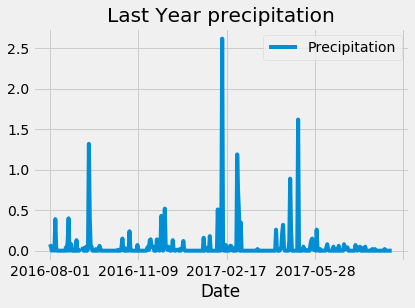

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data will probably need to 
df.plot.line(title="Last Year precipitation")
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['Precipitation'].describe()

count    386.000000
mean       0.048912
std        0.200803
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: Precipitation, dtype: float64

In [25]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
station_num = session.query(distinct(Measurement.station)).count()
print(station_num)

9


In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperatures = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == 'USC00519281').all()
print(temperatures)
                             

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [34]:
# Choose the station with the highest number of temperature observations.
temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
temp_obs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.tobs).\
    filter(func.strftime("%Y-%m", Measurement.date) >= "2016-08").\
    filter(Measurement.station == 'USC00519281').all()
year_temp



[(76.0),
 (76.0),
 (77.0),
 (77.0),
 (81.0),
 (78.0),
 (78.0),
 (81.0),
 (81.0),
 (82.0),
 (80.0),
 (76.0),
 (80.0),
 (76.0),
 (75.0),
 (74.0),
 (82.0),
 (80.0),
 (79.0),
 (81.0),
 (79.0),
 (78.0),
 (77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 

In [60]:
number_temp= len(year_temp)
number_temp

374

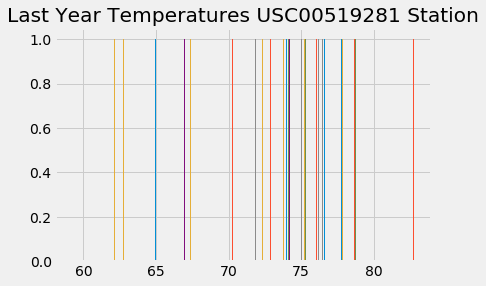

In [63]:
plt.hist(year_temp)
plt.title("Last Year Temperatures USC00519281 Station")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
